In [ ]:
!pip install transformers==3
!pip install tensorflow-gpu
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer
import warnings
warnings.filterwarnings('ignore')
# specify GPU
device = torch.device("cuda")
print(device)
# Chose Language
language="it-IT"
berts={"it-IT":"bert-base-multilingual-cased", "en-US":"bert-base-uncased"}

cuda


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data_dir = "/content/drive/My Drive/Tesi/Code/Intent_Classification"

In [ ]:
class LoadingData():
            
    def __init__(self):
        #Davide="Ingegneria/Magistrale/Tesi/"
        train_file_path = os.path.join(data_dir,"Dataset","Train")
        validation_file_path = os.path.join(data_dir,"Dataset","Validate")
        category_id = 0
        self.cat_to_intent = {}
        self.intent_to_cat = {}
        for dirname, _, filenames in os.walk(train_file_path):
            for filename in filenames:
                
                file_path = os.path.join(dirname, filename)
                intent_id = filename.replace(".txt","")
                self.cat_to_intent[category_id] = intent_id
                self.intent_to_cat[intent_id] = category_id
                category_id+=1
        '''Training data'''
        self.train_data_frame = self.file_to_dataframe(train_file_path)  
        self.train_data_frame = self.train_data_frame.sample(frac = 1)
        
        '''Validation data''' 
        self.validation_data_frame = self.file_to_dataframe(validation_file_path)   
        self.validation_data_frame = self.validation_data_frame.sample(frac = 1)

    def file_to_dataframe(self,file_path,file_path_2=None):
          data = list() 
          for dirname, _, filenames in os.walk(file_path):
              for filename in filenames:
                  file_path = os.path.join(dirname, filename)
                  intent_id = filename.replace(".txt","")
                  data+=self.make_data_for_intent_from_txt(file_path,intent_id,self.intent_to_cat[intent_id])
          if file_path_2!=None:
              for dirname, _, filenames in os.walk(file_path_2):
                  for filename in filenames:
                      file_path_2 = os.path.join(dirname, filename)
                      intent_id = filename.replace(".txt","")
                      data+=self.make_data_for_intent_from_txt(file_path_2,intent_id,self.intent_to_cat[intent_id])      
          return pd.DataFrame(data, columns =['query', 'intent','category'])  
        
        
    def make_data_for_intent_from_txt(self,txt_file,intent_id,cat):
        query_list=[]
        with open(txt_file, 'r') as f:
            for line in f.readlines():
                text=line.replace("\n", "")
                query_list.append((text,intent_id,cat))
        return query_list 

In [ ]:
ld = LoadingData()

In [ ]:
train_df = ld.train_data_frame

In [ ]:
label_map,id2label = ld.intent_to_cat,ld.cat_to_intent

In [ ]:
train_text, val_text, train_labels, val_labels = train_test_split(train_df['query'], train_df['category'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=train_df['category'])

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(berts[language])
bert = BertModel.from_pretrained(berts[language])

9


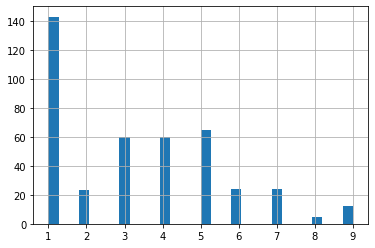

In [ ]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
max_seq_len = max(seq_len)
print(max_seq_len)

In [ ]:
# tokenize and encode sequences in the training set
if max_seq_len>512:
    max_seq_len = 512
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)



In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
print("train_y:",train_y)
# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
print("val_y:",val_y)


train_y: tensor([1, 1, 3, 2, 2, 2, 3, 0, 2, 2, 3, 2, 2, 0, 1, 0, 2, 0, 1, 2, 1, 3, 0, 0,
        2, 0, 2, 1, 2, 1, 1, 0, 0, 3, 3, 0, 3, 2, 3, 1, 2, 0, 2, 1, 0, 0, 3, 0,
        0, 2, 2, 0, 3, 3, 1, 0, 2, 1, 0, 2, 0, 1, 3, 0, 0, 3, 1, 3, 1, 3, 2, 1,
        0, 3, 0, 3, 3, 2, 3, 1, 1, 1, 0, 3, 3, 3, 1, 0, 2, 2, 0, 1, 1, 1, 2, 2,
        0, 0, 0, 1, 2, 0, 1, 2, 3, 2, 0, 0, 1, 3, 3, 1, 1, 3, 1, 2, 2, 0, 3, 3,
        1, 2, 2, 1, 1, 0, 2, 2, 0, 0, 3, 1, 0, 0, 1, 1, 0, 2, 0, 3, 1, 0, 1, 1,
        1, 3, 0, 0, 0, 0, 1, 1, 3, 2, 1, 3, 3, 2, 2, 1, 1, 2, 1, 0, 1, 0, 3, 0,
        2, 3, 3, 0, 3, 1, 3, 0, 3, 1, 3, 0, 0, 1, 0, 3, 0, 2, 2, 0, 1, 0, 1, 0,
        0, 2, 3, 3, 3, 2, 0, 1, 1, 0, 2, 0, 1, 2, 0, 3, 0, 3, 2, 0, 3, 2, 2, 2,
        3, 0, 3, 2, 3, 0, 0, 3, 1, 2, 1, 3, 3, 2, 0, 3, 2, 3, 3, 3, 2, 1, 3, 2,
        1, 3, 0, 3, 1, 3, 0, 3, 2, 1, 0, 3, 0, 0, 0, 3, 2, 0, 1, 3, 0, 3, 1, 0,
        0, 0, 0, 2, 0, 0, 2, 1, 0, 1, 1, 3, 2, 3, 2, 2, 1, 1, 2, 1, 1, 2, 3, 3,
        3, 0, 1, 3, 3, 3, 2, 0,

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert,label_map):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,len(label_map))

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)
        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert,label_map)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.86666667 1.08333333 1.08333333 1.        ]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 50

In [ ]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
    total_labels =[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        # append the model predictions
        total_preds+=list(preds)
        total_labels+=labels.tolist()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    f1 = f1_score(total_labels, total_preds, average='weighted')
    #returns the loss and predictions
    return avg_loss, f1

In [ ]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Calculate elapsed time in minutes.
          #elapsed = format_time(time.time() - t0)

          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            total_preds+=list(preds)
            total_labels+=labels.tolist()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    
    f1 = f1_score(total_labels, total_preds, average='weighted')
    return avg_loss, f1

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, label_map, id2label):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'label_map': label_map,
        'id_map':id2label}
    torch.save(state, filename)

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, f1_train = train()
    
    #evaluate model
    valid_loss, f1_valid = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        file_name = 'topic_saved_weights.pt'
        save_checkpoint(file_name, epoch, model, optimizer, label_map, id2label)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining F1: {f1_train:.3f}')
    print(f'Validation F1: {f1_valid:.3f}')


 Epoch 1 / 50

Evaluating...

Training Loss: 1.368
Validation Loss: 1.250

Training F1: 0.315
Validation F1: 0.422

 Epoch 2 / 50

Evaluating...

Training Loss: 1.265
Validation Loss: 1.157

Training F1: 0.404
Validation F1: 0.366

 Epoch 3 / 50

Evaluating...

Training Loss: 1.174
Validation Loss: 1.080

Training F1: 0.486
Validation F1: 0.436

 Epoch 4 / 50

Evaluating...

Training Loss: 1.147
Validation Loss: 1.066

Training F1: 0.475
Validation F1: 0.369

 Epoch 5 / 50

Evaluating...

Training Loss: 1.058
Validation Loss: 0.991

Training F1: 0.521
Validation F1: 0.546

 Epoch 6 / 50

Evaluating...

Training Loss: 1.090
Validation Loss: 0.975

Training F1: 0.531
Validation F1: 0.578

 Epoch 7 / 50

Evaluating...

Training Loss: 0.997
Validation Loss: 0.887

Training F1: 0.575
Validation F1: 0.616

 Epoch 8 / 50

Evaluating...

Training Loss: 0.963
Validation Loss: 0.893

Training F1: 0.558
Validation F1: 0.634

 Epoch 9 / 50

Evaluating...

Training Loss: 1.006
Validation Loss: 0.9

In [ ]:
path = 'topic_saved_weights.pt'
test_df = ld.validation_data_frame

checkpoint = torch.load(path,map_location=device)
model = checkpoint.get("model")

tokenizer = BertTokenizer.from_pretrained(berts[language])

# weights_path = os.path.join(data_dir,"Weights","topic_saved_weights.pt")
!cp topic_saved_weights.pt /content/drive/My\ Drive/Tesi/Code/Intent_Classification/Weights

# tokenize and encode sequences in the test set
test_text,test_labels = test_df["query"],test_df["category"]

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())
print("test_y:",test_y)

test_y: tensor([2, 2, 3, 2, 0, 0, 2, 2, 2, 3, 1, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 1, 3,
        2, 1, 0, 1, 1, 0, 2, 2, 3, 2, 0, 3, 1, 1, 0, 3, 2, 0, 1, 2, 3, 3, 3, 1,
        3, 1, 1, 3, 2, 0, 3, 0, 3, 0, 1, 2, 2, 0, 2, 1, 0, 2, 3, 1, 2, 2, 3, 2,
        2, 2, 2])


In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       1.00      0.73      0.85        15
           2       0.81      1.00      0.90        30
           3       1.00      0.93      0.97        15

    accuracy                           0.89        75
   macro avg       0.93      0.87      0.89        75
weighted avg       0.91      0.89      0.89        75



In [ ]:
class Prediction:
    def __init__(self):
        path = 'topic_saved_weights.pt'

        checkpoint = torch.load(path,map_location=device)
        self.predictor = checkpoint.get("model")
        self.tokenizer = BertTokenizer.from_pretrained(berts[language])
        self.tag = checkpoint.get("id_map")

    def predict(self,text):
        tokens = self.tokenizer.tokenize(text)
        tokens = tokens[:max_seq_len - 2]
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = input_ids + [0] * (max_seq_len-len(input_ids))
        input_ids = torch.tensor(input_ids).unsqueeze(0)
        input_ids = input_ids.to(device)

        input_mask = [1]*len(tokens) + [0] * (max_seq_len - len(tokens))
        input_mask = torch.tensor(input_mask).unsqueeze(0)
        input_mask = input_mask.to(device)

        logits = self.predictor(input_ids,input_mask)
        prob = torch.nn.functional.softmax(logits,dim=1)
        result = [(self.tag[idx],item *100) for idx,item in enumerate(prob[0].tolist())]
        preds = logits.detach().cpu().numpy()
        pred_val = np.argmax(preds)
        pred_val = self.tag[pred_val]
        return result,pred_val


In [ ]:
pred = Prediction()

print(max_seq_len)

9


In [ ]:
list_input = [
     'di che colore è',
     'che tessitura ha questo oggetto',
     'che cosa è questo',
     'che forma ha',
     'cosa è',
     'è un toroide'] 

for item in list_input:
    confidence,pred_val = pred.predict(item)
    prob = round([i for i in confidence if i[0]==pred_val][0][1],4)
    print("'" + item + "' = " + pred_val + ": " + str(prob))
    print([(i[0],round(i[1],4)) for i in confidence])
    print()

'di che colore è' = color_query: 98.0531
[('texture_query', 0.4333), ('shape_query', 1.4912), ('general_query', 0.0224), ('color_query', 98.0531)]

'che tessitura ha questo oggetto' = texture_query: 75.0615
[('texture_query', 75.0615), ('shape_query', 5.4596), ('general_query', 4.389), ('color_query', 15.09)]

'che cosa è questo' = general_query: 98.7136
[('texture_query', 1.1098), ('shape_query', 0.0995), ('general_query', 98.7136), ('color_query', 0.0771)]

'che forma ha' = shape_query: 99.5111
[('texture_query', 0.2635), ('shape_query', 99.5111), ('general_query', 0.1109), ('color_query', 0.1145)]

'cosa è' = general_query: 98.968
[('texture_query', 0.9201), ('shape_query', 0.0265), ('general_query', 98.968), ('color_query', 0.0854)]

'è un toroide' = shape_query: 97.1035
[('texture_query', 0.9285), ('shape_query', 97.1035), ('general_query', 0.2618), ('color_query', 1.7062)]

